# **Emotion Recognition Task**

Various Imports


In [ ]:
import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
import pandas as pd
import seaborn as sn

Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/dataset/fer2013.csv'
data=pd.read_csv(data_path)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Shape of the Dataset


In [ ]:
data.shape

(35887, 3)



Now, I count the number of examples for each class (emotion) and how the dataset is defined

In [ ]:
data['emotion'].value_counts()


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Defining labels and their subdivision

In [ ]:
emotion_labels = {0: 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happy', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
emotion_total = data['emotion'].value_counts(sort=False).reset_index()
emotion_total.columns = ['emotion', 'number']
emotion_total['emotion'] = emotion_total['emotion'].map(emotion_labels)


In [ ]:
emotion_total

,emotion,number
0,Angry,4953
1,Disgust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


Print some examples of images in the Dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

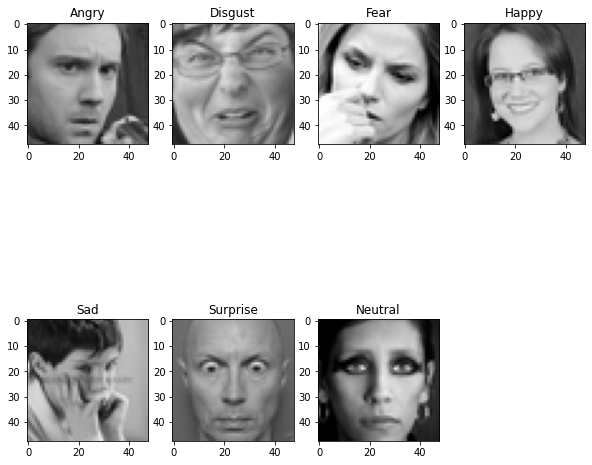

In [ ]:
def imageshow(row):
    pixels = row['pixels']
    emotion = emotion_labels[row['emotion']] 
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(figsize=(10,10))

for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = imageshow(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show() 

PREPROCESSING


I start from splitting the Dataset in 3 parts: Training, Validation and Test 

In [ ]:
data_train = data[data['Usage']=='Training']
data_val   = data[data['Usage']=='PublicTest']
data_test  = data[data['Usage']=='PrivateTest']
print("train shape = ", data_train.shape)
print("validation shape = ", data_val.shape)
print("test shape = ", data_test.shape)

train shape =  (28709, 3)
validation shape =  (3589, 3)
test shape =  (3589, 3)


As it can be seen by the shapes, the size of the Train set is almost 80% of the entire Dataset, while validation and test set are equals and represent the 10% of the Dataset

Now, i define some parameters that we will need after


In [ ]:
num_classes = 7 
img_shape = 48
num_epochs = 50 
batch_size = 128 

Now, to prepare the data for processing, I use a function that converts the strings in lists of integers, than reshapes and encodes the data, then I apply that to my 3 different sets

In [ ]:
def Prep(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,img_shape, img_shape,1)/255.0   
    Y = to_categorical(df['emotion'], num_classes)  
    print("X_", dataName," shape = ",X.shape)
    print("Y_", dataName," shape = ",Y.shape)
    return X, Y

X_train, Y_train = Prep(data_train, "train")
X_val, Y_val = Prep(data_val, "validation")
X_test, Y_test = Prep(data_test, "test")




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


X_ train  shape =  (28709, 48, 48, 1)
Y_ train  shape =  (28709, 7)
X_ validation  shape =  (3589, 48, 48, 1)
Y_ validation  shape =  (3589, 7)
X_ test  shape =  (3589, 48, 48, 1)
Y_ test  shape =  (3589, 7)


I define the CNN model

In [ ]:
model = Sequential()


#First Convolutional module
model.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu', input_shape=(img_shape, img_shape, 1))) 
model.add(BatchNormalization())


#Second Convolutional module
model.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))


#Third Convolutional module
model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))


#Fourth Convolutional module
model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))


#Flatten module
model.add(Flatten())


#First Dense module
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


#Second Dense module
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


#Third Dense module
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


#Output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 128)       1280      
_________________________________________________________________
batch_normalization_21 (Batc (None, 46, 46, 128)       512       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 128)       147584    
_________________________________________________________________
batch_normalization_22 (Batc (None, 44, 44, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)       

In [ ]:
history = model.fit(X_train, Y_train, batch_size, num_epochs, validation_data = (X_val, Y_val))

Epoch 1/50
225/225 [==============================] - 32s 134ms/step - loss: 2.3603 - accuracy: 0.1873 - val_loss: 1.8430 - val_accuracy: 0.2494
Epoch 2/50
225/225 [==============================] - 30s 133ms/step - loss: 1.8809 - accuracy: 0.2508 - val_loss: 1.7717 - val_accuracy: 0.2658
Epoch 3/50
225/225 [==============================] - 30s 133ms/step - loss: 1.7230 - accuracy: 0.3098 - val_loss: 1.6970 - val_accuracy: 0.3293
Epoch 4/50
225/225 [==============================] - 30s 133ms/step - loss: 1.6183 - accuracy: 0.3642 - val_loss: 1.7002 - val_accuracy: 0.3313
Epoch 5/50
225/225 [==============================] - 30s 133ms/step - loss: 1.5387 - accuracy: 0.3985 - val_loss: 1.4867 - val_accuracy: 0.4274
Epoch 6/50
225/225 [==============================] - 30s 133ms/step - loss: 1.4756 - accuracy: 0.4274 - val_loss: 1.4148 - val_accuracy: 0.4578
Epoch 7/50
225/225 [==============================] - 30s 133ms/step - loss: 1.4196 - accuracy: 0.4494 - val_loss: 1.3437 - val_ac

Accuracy and loss Graphs

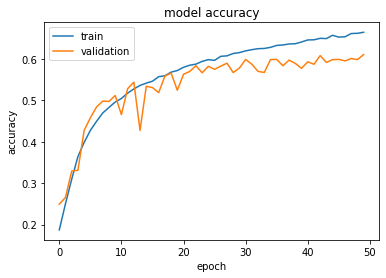

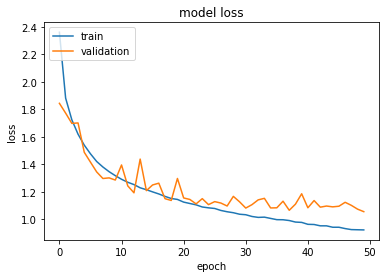

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

113/113 [==============================] - 2s 14ms/step - loss: 1.0097 - accuracy: 0.6252
Test accuracy: 0.6252437829971313


Confusion Matrix without normalization

In [ ]:
labels_confusion_matrix = {'Angry' : 0, 'Disgust' : 1, 'Fear' : 2, 'Happy' : 3, 'Sad' : 4, 'Surprise' : 5, 'Neutral' : '6'}

In [ ]:
def print_confusion_matrix_pandas(model, images, labels):
    num_classes = 7
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(np.argmax(labels, axis = 1), np.argmax(predictions,axis=1))
    # Plot the confusion matrix as an image.
    class_names = labels_confusion_matrix.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.axis([-0.5, 7.5, 7.5, -0.5])
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

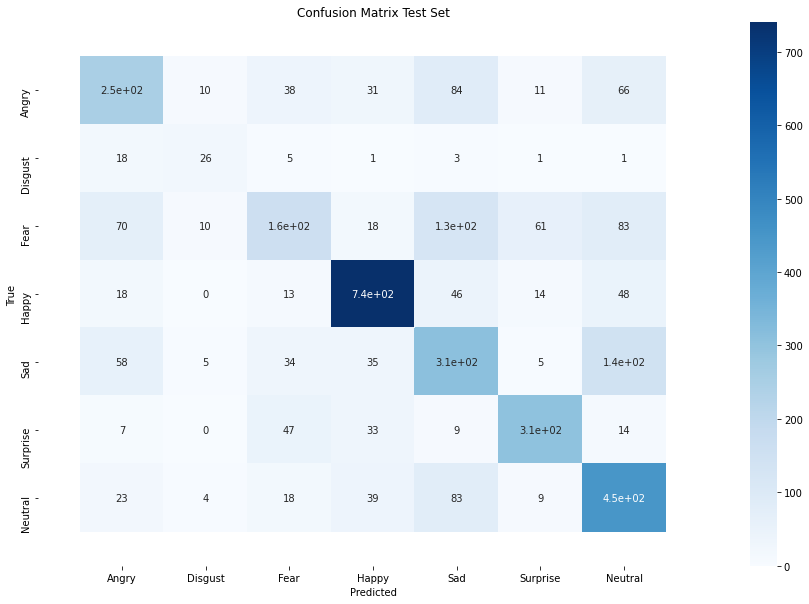

In [ ]:
print_confusion_matrix_pandas(model, X_test, Y_test)

Confusion Matrix with normalization

In [ ]:
def print_normalized_confusion_matrix_pandas(model, images, labels):
    num_classes = 7
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(np.argmax(labels, axis = 1), np.argmax(predictions,axis=1))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Plot the confusion matrix as an image.
    class_names = labels_confusion_matrix.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.axis([-0.5, 7.5, 7.5, -0.5])
    plt.title('Normalized Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

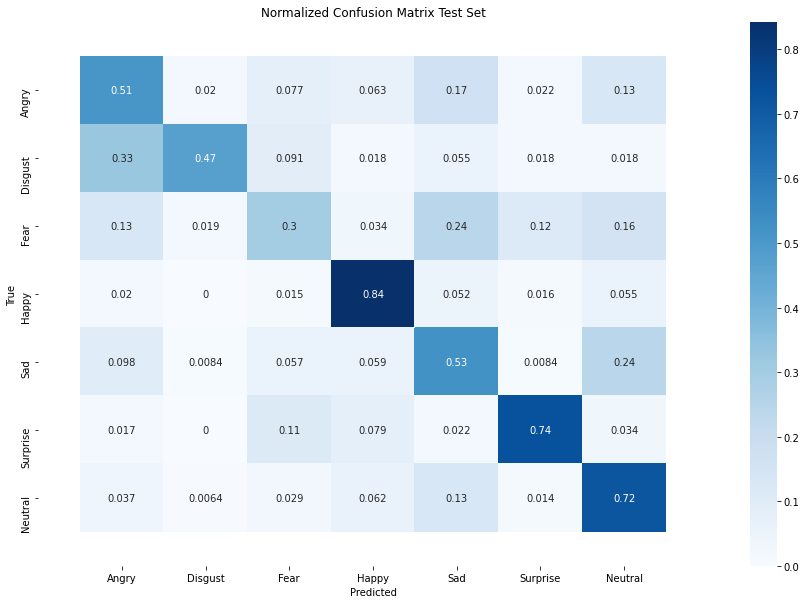

In [ ]:
print_normalized_confusion_matrix_pandas(model, X_test, Y_test)